##### 1.載入套件

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.stats import zscore
import statsmodels.api as sm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc as sk_auc,
    recall_score,
    precision_score,
    fbeta_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer

from imblearn.over_sampling import SMOTENC
from category_encoders import TargetEncoder

In [47]:
import os

def save_plot(fig, filename, model_name='random_forest'):
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)


##### 2.讀取資料與切分訓驗測集

In [38]:
df = pd.read_csv('../raw_data/train_2025.csv')
X = df.drop(columns=['claim_number', 'fraud'])  # 移除 ID 與目標欄位
y = df['fraud']
# 切分資料集：60% 訓練、20% 驗證、20% 測試
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

##### 3.資料清洗與特徵欄位分類

In [39]:
# 以下特徵工程跟logit一樣，可省略不看
mask = ~X_train['zip_code'].astype(str).str.startswith('0')
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

cat_cols = [
    'gender', 'marital_status', 'high_education_ind', 'address_change_ind',
    'living_status', 'zip_code', 'claim_date', 'claim_day_of_week', 'accident_site',
    'witness_present_ind', 'channel', 'policy_report_filed_ind', 'vehicle_category', 'vehicle_color'
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

##### 4.自訂欄位轉換器類別與函數

In [40]:
def encode_gender(X): return (X == 'M').astype(int)
def encode_living_status(X): return (X == 'Own').astype(int)

# class Zip3Extractor(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None): self.feature_names_in_ = list(X.columns); return self
#     def transform(self, X): return pd.DataFrame(X, columns=self.feature_names_in_).apply(lambda col: col.astype(str).str[:3])
#     def get_feature_names_out(self, input_features=None): return [f"{feat}_zip3" for feat in (input_features or ['zip3'])]

# class ExtractMonthYear(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None): self.feature_names_in_ = list(X.columns); return self
#     def transform(self, X): return pd.to_datetime(X.iloc[:, 0], errors='coerce').dt.to_period('M').astype(str).to_frame()
#     def get_feature_names_out(self, input_features=None): return [f"{feat}_month_year" for feat in (input_features or ['claim_date'])]

class Zip3Extractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = (
            list(X.columns) if hasattr(X, 'columns') else [f'x{i}' for i in range(X.shape[1])]
        )
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.feature_names_in_)
        return df.apply(lambda col: col.astype(str).str[:3])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return [f"{feat}_zip3" for feat in input_features]
    
class ExtractMonthYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = (
            list(X.columns) if hasattr(X, 'columns') else [f'x{i}' for i in range(X.shape[1])]
        )
        return self

    def transform(self, X):
        s = pd.Series(X[:, 0]) if isinstance(X, np.ndarray) else X.iloc[:, 0]
        date = pd.to_datetime(s, errors='coerce')
        return date.dt.to_period('M').astype(str).to_frame()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return [f"{feat}_month_year" for feat in input_features]



class TargetEncoderWrapper(TargetEncoder):
    def get_feature_names_out(self, input_features=None): return input_features if input_features is not None else self.feature_names_in_


##### 5.設定各欄位的轉換流程

In [41]:
marital_witness_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))])

gender_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('label_encoder', FunctionTransformer(encode_gender, validate=False, feature_names_out='one-to-one'))])

living_status_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('label_encoder', FunctionTransformer(encode_living_status, validate=False, feature_names_out='one-to-one'))])

zip3_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('zip3_extract', Zip3Extractor()), 
    ('target', TargetEncoderWrapper())])

claim_date_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('extract_month_year', ExtractMonthYear()), ('target', TargetEncoderWrapper())])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())])

target_cat_cols = ['claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']

target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('target', TargetEncoderWrapper())])


##### 6.整合特徵轉換流程為 ColumnTransformer

In [42]:
# 整合所有欄位轉換 
transformers = [
    ('marital_witness', marital_witness_pipeline, ['marital_status', 'witness_present_ind']),
    ('gender', gender_pipeline, ['gender']),
    ('living_status', living_status_pipeline, ['living_status']),
    ('zip_code', zip3_pipeline, ['zip_code']),
    ('claim_date', claim_date_pipeline, ['claim_date']),
    ('num', num_pipeline, num_cols),
    ('cat_imputer', target_cat_pipeline, target_cat_cols)
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough')


##### 7.設定超參數與交叉驗證策略

In [43]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt"],
    'class_weight': [None, 'balanced']
}
grid = ParameterGrid(param_grid)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

##### 8.執行 Grid Search 與交叉驗證訓練模型

In [44]:
results = []

# 1. 計時開始
start_time = time.time() 

for idx, param in enumerate(grid):
    aucs = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        X_tr_f, X_val_f = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr_f, y_val_f = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        z_scores = X_tr_f[num_cols].apply(zscore)
        mask_no_outliers = (z_scores.abs() < 3).all(axis=1)
        X_tr_f = X_tr_f[mask_no_outliers].reset_index(drop=True)
        y_tr_f = y_tr_f[mask_no_outliers].reset_index(drop=True)

        # 每一次迴圈都要重新 fit-transform 特徵工程
        X_tr_transformed = preprocessor.fit_transform(X_tr_f, y_tr_f)
        X_val_transformed = preprocessor.transform(X_val_f)

        categorical_feature_indices = [
            i for i, col in enumerate(preprocessor.get_feature_names_out())
            if col.startswith('gender__') or col.startswith('living_status__') or
               col.startswith('zip_code__') or col.startswith('claim_date__') or
               col.startswith('cat_imputer__') or col.startswith('remainder__')
        ]
        smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
        X_resampled, y_resampled = smote_nc.fit_resample(X_tr_transformed, y_tr_f)

        # 訓練模型
        model = RandomForestClassifier(**param, random_state=42)
        model.fit(X_resampled, y_resampled)

        # 驗證並計算 AUC
        y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
        auc = roc_auc_score(y_val_f, y_pred_proba)
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    results.append((param, mean_auc))
    print(f"Params {param} | Mean AUC: {mean_auc:.4f}")

end_time = time.time()
print(f"執行時間: {end_time - start_time:.2f} 秒")

#  找出最佳組合
best_param, best_score = max(results, key=lambda x: x[1])
print("\n最佳超參數:", best_param)
print("平均 ROC-AUC:", best_score)


Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} | Mean AUC: 0.6500
Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} | Mean AUC: 0.6549
Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100} | Mean AUC: 0.6526
Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300} | Mean AUC: 0.6544
Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} | Mean AUC: 0.6548
Params {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} | Mean AUC: 0.6570
Params {'class_weight': None, 'max_dep

##### 9.計算最佳閾值與驗證集評估

In [45]:
final_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_param)
final_rf.fit(X_resampled, y_resampled)

X_valid_transformed = preprocessor.transform(X_valid)
y_proba = final_rf.predict_proba(X_valid_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = sk_auc(fpr, tpr)

# 以 Recall 下限 尋找最佳閾值
target_recall = 0.8
best_threshold, best_prec = 0, 0
for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    recall = recall_score(y_valid, y_pred_thresh)
    precision = precision_score(y_valid, y_pred_thresh)
    if recall >= target_recall and precision > best_prec:
        best_threshold, best_prec = threshold, precision

print(f'最佳 Recall 下界時的閾值：{best_threshold:.4f}')


d:\users\anaconda\envs\Fraud_Detection\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


最佳 Recall 下界時的閾值：0.3141


##### 10.測試集預測與繪製特徵重要性圖

測試集績效報告：
              precision    recall  f1-score   support

           0       0.92      0.42      0.58      3031
           1       0.21      0.82      0.33       569

    accuracy                           0.48      3600
   macro avg       0.57      0.62      0.46      3600
weighted avg       0.81      0.48      0.54      3600


auc: 0.6664
f2-score: 0.5160


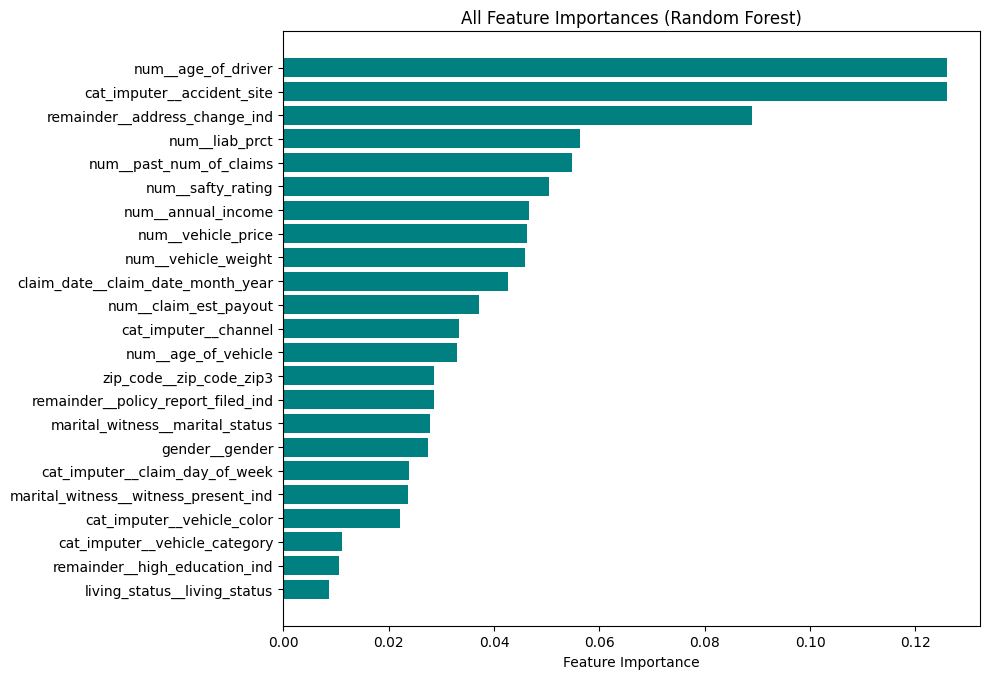

In [ ]:
X_test_transformed = preprocessor.transform(X_test)
y_test_proba = final_rf.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# 計算測試集上的績效指標
print("測試集績效報告：")
print(classification_report(y_test, y_test_pred))
print(f'\nauc: {roc_auc:.04f}')
print(f'f2-score: {fbeta_score(y_test, y_test_pred, beta=2):.04f}')

# 從訓練好的隨機森林模型取得特徵重要性
importances = final_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# 建立 DataFrame 並排序（由高到低）
feat_imp = pd.DataFrame({
    'feature': feature_names, 'importance': importances}
    ).sort_values(by='importance', ascending=False)

# 畫圖：橫向長條圖（從低到高畫起）
plt.figure(figsize=(10, len(feat_imp) * 0.3)) # 高度依照特徵數量自動調整
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1], color='teal')
plt.xlabel("Feature Importance")
plt.title("All Feature Importances (Random Forest)")
plt.tight_layout()
save_plot(plt.gcf(), 'feature_importance.png', model_name='random_forest')
plt.show()